In [1]:
%pylab inline 
import numpy as np
from astropy.io import fits
import tensorflow_probability as tfp
import tensorflow as tf
from flowpm.angular_power_tf import  measure_power_spectrum_tf
import jax
import jax_cosmo as jc
import sys
sys.path.insert(0,'/Users/dl264294/Desktop/github/howls_step3')
from lenspack.image.transforms import starlet2d
from lenspack.peaks import peaks_histogram
from howls.peak_counts import get_wavelet_normalization, wavelet_peak_counts, wavelet_l1_norm


Populating the interactive namespace from numpy and matplotlib


In [2]:
lista=open('mappe/list','r')

In [3]:
ar=[]
for k,i in zip(range(10),lista):
    i=i.replace("\n","")
    data=fits.open('mappe/'+str(i)+'.fits')
    data=data[0].data
    ar.append(data)
    exec(f'data_{k} = data')


In [4]:
angular_array=[]
peak_array_kmap=[]
for i,k in zip(range(10),ar):
    ell_,ps_example_ = measure_power_spectrum_tf(k, 5.,128)
    angular_array.append(ps_example_)
    wtnorm = get_wavelet_normalization(k, nscales=5)
    bin_edges = np.stack([n*np.linspace(-0.04,0.25,16) for n in wtnorm],axis=0)
    peak_counts_kmap = wavelet_peak_counts(k, bin_edges=bin_edges)
    peak_array_kmap.append(peak_counts_kmap)
    exec(f'ps_{i} = ps_example_')
    exec(f'pcountkmap_{i} = peak_counts_kmap')

In [5]:
angular_mean=np.mean(angular_array,axis=0)
angular_std=np.std(angular_array,axis=0)

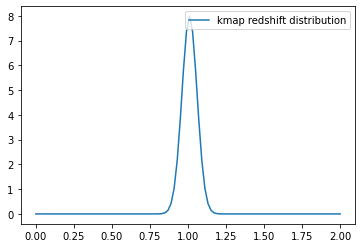

In [6]:
#let's compute the redshift ditribution from our k-map
z = linspace(0,2,100)                            #redshift array
pz = zeros_like(z)                           #redshift histogram
pz[50] =1.                                    #redshift histogram
nzs_s=jc.redshift.kde_nz(z, pz,bw=0.05)     #redshift distribution
nzs = [nzs_s]
plot(z, nzs_s(z),label='kmap redshift distribution')
legend()

In [7]:
probes_kmap=[ jc.probes.WeakLensing(nzs, sigma_e=0.26) ]

In [8]:
proto_tensor = tf.make_tensor_proto(ell_) 
ell=tf.make_ndarray(proto_tensor)
cosmo_jc = jc.Planck15()
# And compute the data vector
cls_kmap = jc.angular_cl.angular_cl(cosmo_jc,ell, probes_kmap)

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


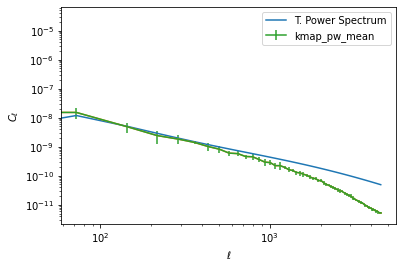

In [9]:
loglog(ell, cls_kmap[0],label='T. Power Spectrum')
loglog(ell_, angular_mean)
ylabel(r'$C_\ell$')
xlabel(r'$\ell$')
errorbar(ell_, angular_mean, yerr=angular_std, label='kmap_pw_mean')
legend()
#savefig('power_mean_err.png',dpi=150)

<ipython-input-10-eab660af9fd9>:3: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  xlim([0,1000])


(-1.0, 1.0)

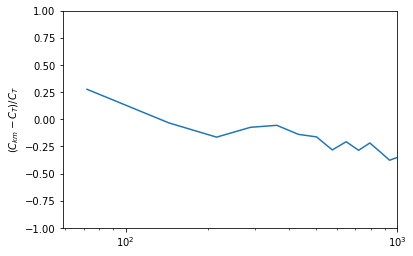

In [10]:
semilogx(ell_, (angular_mean-cls_kmap[0])/cls_kmap[0], label='kmap_pw_mean')
ylabel(r'$(C_{km}-C_{T})/C_{T}$')
xlim([0,1000])
ylim([-1,1])

In [11]:
peak_kmap_mean=np.mean(peak_array_kmap,axis=0)

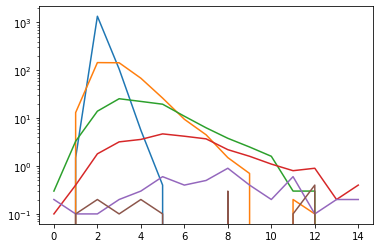

In [12]:
plot(peak_kmap_mean[0])
plot(peak_kmap_mean[1])
plot(peak_kmap_mean[2])
plot(peak_kmap_mean[3])
plot(peak_kmap_mean[4])
plot(peak_kmap_mean[5])
yscale('log')

In [13]:
lista_mnu=open('/Users/dl264294/Downloads/Maps10/WLonv/list_mnu','r')


In [14]:
ar_mnu=[]
for k,i in zip(range(10),lista_mnu):
    i=i.replace("\n","")
    data=fits.open('/Users/dl264294/Downloads/Maps10/WLonv/'+str(i)+'.fits')
    data=data[0].data
    ar_mnu.append(data)
    exec(f'datamnu_{k} = data')

In [15]:
angular_array_mnu=[]
peak_array=[]
for i,k in zip(range(10),ar_mnu):
    mnu_map_new = k[:,:,tf.newaxis]
    mnu_map_rescale= tf.image.resize(mnu_map_new,[128,128],method='gaussian')
    mnumap_new=tf.squeeze(mnu_map_rescale)
    ell_,ps_example_mnu = measure_power_spectrum_tf(tf.cast(mnumap_new,dtype=tf.complex64), 5.,128)
    angular_array_mnu.append(ps_example_mnu)
    wtnorm = get_wavelet_normalization(mnumap_new, nscales=5)
    bin_edges = np.stack([n*np.linspace(-0.04,0.25,16) for n in wtnorm],axis=0)
    peak_counts = wavelet_peak_counts(mnumap_new, bin_edges=bin_edges)
    peak_array.append(peak_counts)
    exec(f'psmnu_{i} = ps_example_mnu')
    exec(f'pcount_{i} = peak_counts')

In [16]:
peak_mean=np.mean(peak_array,axis=0)
angular_mnu_mean=np.mean(angular_array_mnu,axis=0)
angular_mnu_std=np.std(angular_array_mnu,axis=0)

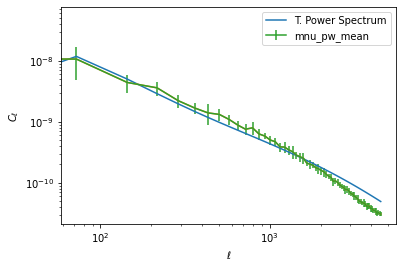

In [17]:
loglog(ell_, cls_kmap[0],label='T. Power Spectrum')
loglog(ell_, angular_mnu_mean, )
ylabel(r'$C_\ell$')
xlabel(r'$\ell$')
errorbar(ell_, angular_mnu_mean, yerr=angular_mnu_std, label='mnu_pw_mean')
legend()

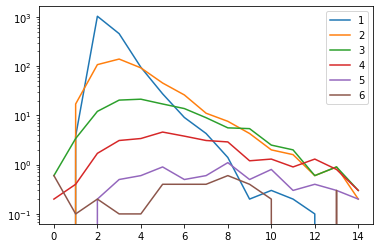

In [18]:
plot(peak_mean[0],label='1')
plot(peak_mean[1],label='2')
plot(peak_mean[2],label='3')
plot(peak_mean[3],label='4')
plot(peak_mean[4],label='5')
plot(peak_mean[5],label='6')
legend()
yscale('log')

In [19]:
#Let's comparethe two simulations

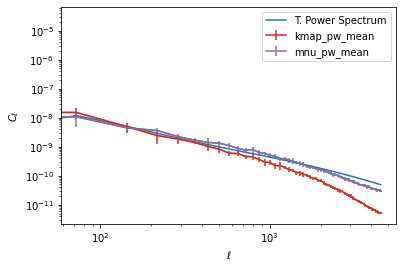

In [20]:
loglog(ell_, cls_kmap[0],label='T. Power Spectrum')
loglog(ell_, angular_mean)
loglog(ell_, angular_mnu_mean)
ylabel(r'$C_\ell$')
xlabel(r'$\ell$')
errorbar(ell_, angular_mean, yerr=angular_std,label='kmap_pw_mean')
errorbar(ell_, angular_mnu_mean, yerr=angular_mnu_std, label='mnu_pw_mean')
legend()

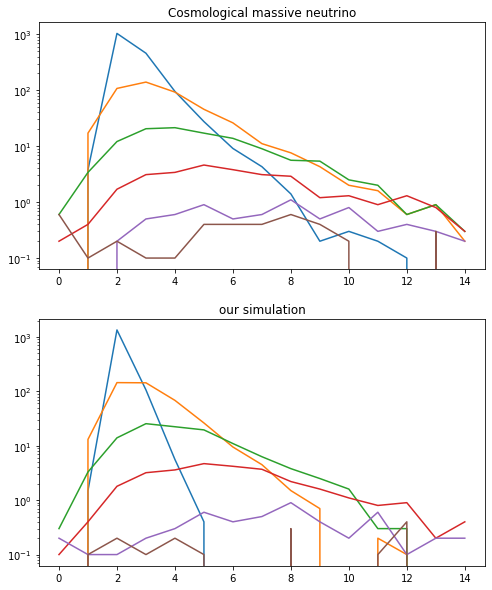

In [21]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,10))
for i in range(6):
    ax1.semilogy(peak_mean[i])
    ax1.set_title('Cosmological massive neutrino')
for i in range(6):
    yscale('log')
    ax2.semilogy(peak_kmap_mean[i])
    ax2.set_title('our simulation')


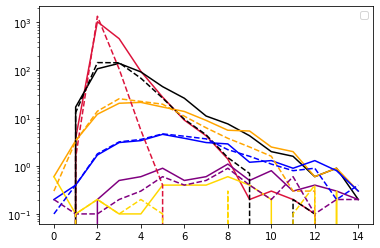

In [22]:
plot(peak_mean[0], color='crimson')
plot(peak_mean[1],color='k')
plot(peak_mean[2],color='orange')
plot(peak_mean[3],color='blue')
plot(peak_mean[4],color='purple')
plot(peak_mean[5],color='gold')
plot(peak_kmap_mean[0], color='crimson',linestyle='dashed')
plot(peak_kmap_mean[1],color='k',linestyle='dashed')
plot(peak_kmap_mean[2],color='orange',linestyle='dashed')
plot(peak_kmap_mean[3],color='blue',linestyle='dashed')
plot(peak_kmap_mean[4],color='purple',linestyle='dashed')
plot(peak_kmap_mean[5],color='gold',linestyle='dashed')
legend()
yscale('log')